In [1]:
!nvidia-smi

Wed Oct 27 12:46:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import math
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import skimage.io as io
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models,layers
from tensorflow.keras.utils import get_file
import re
from collections import namedtuple
import tensorflow.keras.backend as K

# Model train from scratch

In [4]:
GlobalParams = namedtuple('GlobalParams', ['batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate', 'num_classes',
                                           'width_coefficient', 'depth_coefficient', 'depth_divisor', 'min_depth',
                                           'drop_connect_rate'])
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)

BlockArgs = namedtuple('BlockArgs', ['kernel_size', 'num_repeat', 'input_filters', 'output_filters', 'expand_ratio',
                                     'id_skip', 'strides', 'se_ratio'])
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

# IMAGENET_WEIGHTS = {

#     'efficientnet-b0': {
#         'name': 'efficientnet-b0_imagenet_1000.h5',
#         'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b0_imagenet_1000.h5',
#         'md5': 'bca04d16b1b8a7c607b1152fe9261af7',
#     },

#     'efficientnet-b1': {
#         'name': 'efficientnet-b1_imagenet_1000.h5',
#         'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b1_imagenet_1000.h5',
#         'md5': 'bd4a2b82f6f6bada74fc754553c464fc',
#     },

#     'efficientnet-b2': {
#         'name': 'efficientnet-b2_imagenet_1000.h5',
#         'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b2_imagenet_1000.h5',
#         'md5': '45b28b26f15958bac270ab527a376999',
#     },

#     'efficientnet-b3': {
#         'name': 'efficientnet-b3_imagenet_1000.h5',
#         'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b3_imagenet_1000.h5',
#         'md5': 'decd2c8a23971734f9d3f6b4053bf424',
#     },

#     'efficientnet-b4': {
#         'name': 'efficientnet-b4_imagenet_1000.h5',
#         'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b4_imagenet_1000.h5',
#         'md5': '01df77157a86609530aeb4f1f9527949',
#     },

#     'efficientnet-b5': {
#         'name': 'efficientnet-b5_imagenet_1000.h5',
#         'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b5_imagenet_1000.h5',
#         'md5': 'c31311a1a38b5111e14457145fccdf32',
#     }

# }


def round_filters(filters, global_params):
    """Round number of filters."""
    multiplier = global_params.width_coefficient
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    if not multiplier:
        return filters

    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """Round number of repeats."""
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def get_efficientnet_params(model_name, override_params=None):
    """Get efficientnet params based on model name."""
    params_dict = {
        # (width_coefficient, depth_coefficient, resolution, dropout_rate)
        # Note: the resolution here is just for reference, its values won't be used.
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.3),
        'efficientnet-b5': (1.6, 2.2, 456, 0.3),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    }
    if model_name not in params_dict.keys():
        raise KeyError('There is no model named {}.'.format(model_name))

    width_coefficient, depth_coefficient, _, dropout_rate = params_dict[model_name]

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=0.2,
        num_classes=10,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None)

    if override_params:
        global_params = global_params._replace(**override_params)

    decoder = BlockDecoder()
    return decoder.decode(blocks_args), global_params


class BlockDecoder(object):
    """Block Decoder for readability."""

    @staticmethod
    def _decode_block_string(block_string):
        """Gets a block through a string notation of arguments."""
        assert isinstance(block_string, str)
        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        if 's' not in options or len(options['s']) != 2:
            raise ValueError('Strides options should be a pair of integers.')

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            strides=[int(options['s'][0]), int(options['s'][1])]
        )

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    def decode(self, string_list):
        """Decodes a list of string notations to specify blocks inside the network.
        Args:
          string_list: a list of strings, each string is a notation of block.
        Returns:
          A list of namedtuples to represent blocks arguments.
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(self._decode_block_string(block_string))
        return blocks_args

    def encode(self, blocks_args):
        """Encodes a list of Blocks to a list of strings.
        Args:
          blocks_args: A list of namedtuples to represent blocks arguments.
        Returns:
          a list of strings, each string is a notation of block.
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(self._encode_block_string(block))
        return block_strings


class Swish(layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, inputs, **kwargs):
        return tf.nn.swish(inputs)

    def get_config(self):
        config = super().get_config()
        config['name'] = self.name
        return config


def SEBlock(block_args, **kwargs):
    num_reduced_filters = max(
        1, int(block_args.input_filters * block_args.se_ratio))
    filters = block_args.input_filters * block_args.expand_ratio

    spatial_dims = [1, 2]

    try:
        block_name = kwargs['block_name']
    except KeyError:
        block_name = ''

    def block(inputs):
        x = inputs
        x = layers.Lambda(lambda a: K.mean(a, axis=spatial_dims, keepdims=True))(x)
        x = layers.Conv2D(
            num_reduced_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding='same',
            name=block_name + 'se_reduce_conv2d',
            use_bias=True
        )(x)

        x = Swish(name=block_name + 'se_swish')(x)

        x = layers.Conv2D(
            filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding='same',
            name=block_name + 'se_expand_conv2d',
            use_bias=True
        )(x)

        x = layers.Activation('sigmoid')(x)
        out = layers.Multiply()([x, inputs])
        return out

    return block


class DropConnect(layers.Layer):

    def __init__(self, drop_connect_rate, **kwargs):
        super().__init__(**kwargs)
        self.drop_connect_rate = drop_connect_rate

    def call(self, inputs, **kwargs):
        def drop_connect():
            keep_prob = 1.0 - self.drop_connect_rate

            # Compute drop_connect tensor
            batch_size = tf.shape(inputs)[0]
            random_tensor = keep_prob
            random_tensor += tf.random.uniform([batch_size, 1, 1, 1], dtype=inputs.dtype)
            binary_tensor = tf.floor(random_tensor)
            output = tf.math.divide(inputs, keep_prob) * binary_tensor
            return output

        return K.in_train_phase(drop_connect(), inputs, training=None)

    def get_config(self):
        config = super().get_config()
        config['drop_connect_rate'] = self.drop_connect_rate
        return config


def conv_kernel_initializer(shape, dtype=K.floatx()):

    kernel_height, kernel_width, _, out_filters = shape
    fan_out = int(kernel_height * kernel_width * out_filters)
    return tf.random.normal(
        shape, mean=0.0, stddev=np.sqrt(2.0 / fan_out), dtype=dtype)


def dense_kernel_initializer(shape, dtype=K.floatx()):
    init_range = 1.0 / np.sqrt(shape[1])
    return tf.random.uniform(shape, -init_range, init_range, dtype=dtype)


def MBConvBlock(block_args, global_params, idx, drop_connect_rate=None):
    filters = block_args.input_filters * block_args.expand_ratio
    batch_norm_momentum = global_params.batch_norm_momentum
    batch_norm_epsilon = global_params.batch_norm_epsilon
    has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)

    block_name = 'blocks_' + str(idx) + '_'

    def block(inputs):
        x = inputs

        # Expansion phase
        if block_args.expand_ratio != 1:
            expand_conv = layers.Conv2D(filters,
                                        kernel_size=[1, 1],
                                        strides=[1, 1],
                                        kernel_initializer=conv_kernel_initializer,
                                        padding='same',
                                        use_bias=False,
                                        name=block_name + 'expansion_conv2d'
                                        )(x)
            bn0 = layers.BatchNormalization(momentum=batch_norm_momentum,
                                            epsilon=batch_norm_epsilon,
                                            name=block_name + 'expansion_batch_norm')(expand_conv)

            x = Swish(name=block_name + 'expansion_swish')(bn0)

        # Depth-wise convolution phase
        kernel_size = block_args.kernel_size
        depthwise_conv = layers.DepthwiseConv2D(
            [kernel_size, kernel_size],
            strides=block_args.strides,
            depthwise_initializer=conv_kernel_initializer,
            padding='same',
            use_bias=False,
            name=block_name + 'depthwise_conv2d'
        )(x)
        bn1 = layers.BatchNormalization(momentum=batch_norm_momentum,
                                        epsilon=batch_norm_epsilon,
                                        name=block_name + 'depthwise_batch_norm'
                                        )(depthwise_conv)
        x = Swish(name=block_name + 'depthwise_swish')(bn1)

        if has_se:
            x = SEBlock(block_args, block_name=block_name)(x)

        # Output phase
        project_conv = layers.Conv2D(
            block_args.output_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding='same',
            name=block_name + 'output_conv2d',
            use_bias=False)(x)
        x = layers.BatchNormalization(momentum=batch_norm_momentum,
                                      epsilon=batch_norm_epsilon,
                                      name=block_name + 'output_batch_norm'
                                      )(project_conv)
        if block_args.id_skip:
            if all(
                    s == 1 for s in block_args.strides
            ) and block_args.input_filters == block_args.output_filters:
                # only apply drop_connect if skip presents.
                if drop_connect_rate:
                    x = DropConnect(drop_connect_rate)(x)
                x = layers.add([x, inputs])

        return x

    return block


def freeze_efficientunet_first_n_blocks(model, n):
    mbblock_nr = 0
    while True:
        try:
            model.get_layer('blocks_{}_output_batch_norm'.format(mbblock_nr))
            mbblock_nr += 1
        except ValueError:
            break

    all_block_names = ['blocks_{}_output_batch_norm'.format(i) for i in range(mbblock_nr)]
    all_block_index = []
    for idx, layer in enumerate(model.layers):
        if layer.name == all_block_names[0]:
            all_block_index.append(idx)
            all_block_names.pop(0)
            if len(all_block_names) == 0:
                break
    n_blocks = len(all_block_index)

    if n <= 0:
        print('n is less than or equal to 0, therefore no layer will be frozen.')
        return
    if n > n_blocks:
        raise ValueError("There are {} blocks in total, n cannot be greater than {}.".format(n_blocks, n_blocks))

    idx_of_last_block_to_be_frozen = all_block_index[n - 1]
    for layer in model.layers[:idx_of_last_block_to_be_frozen + 1]:
        layer.trainable = False


def unfreeze_efficientunet(model):
    for layer in model.layers:
        layer.trainable = True
def efficientnet(input_shape, blocks_args_list, global_params):
    batch_norm_momentum = global_params.batch_norm_momentum
    batch_norm_epsilon = global_params.batch_norm_epsilon

    # Stem part
    model_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(
        filters=round_filters(32, global_params),
        kernel_size=[3, 3],
        strides=[2, 2],
        kernel_initializer=conv_kernel_initializer,
        padding='same',
        use_bias=False,
        name='stem_conv2d'
    )(model_input)

    x = layers.BatchNormalization(
        momentum=batch_norm_momentum,
        epsilon=batch_norm_epsilon,
        name='stem_batch_norm'
    )(x)

    x = Swish(name='stem_swish')(x)

    # Blocks part
    idx = 0
    drop_rate = global_params.drop_connect_rate
    n_blocks = sum([blocks_args.num_repeat for blocks_args in blocks_args_list])
    drop_rate_dx = drop_rate / n_blocks

    for blocks_args in blocks_args_list:
        assert blocks_args.num_repeat > 0
        # Update block input and output filters based on depth multiplier.
        blocks_args = blocks_args._replace(
            input_filters=round_filters(blocks_args.input_filters, global_params),
            output_filters=round_filters(blocks_args.output_filters, global_params),
            num_repeat=round_repeats(blocks_args.num_repeat, global_params)
        )

        # The first block needs to take care of stride and filter size increase.
        x = MBConvBlock(blocks_args, global_params, idx, drop_connect_rate=drop_rate_dx * idx)(x)
        idx += 1

        if blocks_args.num_repeat > 1:
            blocks_args = blocks_args._replace(input_filters=blocks_args.output_filters, strides=[1, 1])

        for _ in range(blocks_args.num_repeat - 1):
            x = MBConvBlock(blocks_args, global_params, idx, drop_connect_rate=drop_rate_dx * idx)(x)
            idx += 1

    # Head part
    x = layers.Conv2D(
        filters=round_filters(1280, global_params),
        kernel_size=[1, 1],
        strides=[1, 1],
        kernel_initializer=conv_kernel_initializer,
        padding='same',
        use_bias=False,
        name='head_conv2d'
    )(x)

    x = layers.BatchNormalization(
        momentum=batch_norm_momentum,
        epsilon=batch_norm_epsilon,
        name='head_batch_norm'
    )(x)

    x = Swish(name='head_swish')(x)

    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)

    if global_params.dropout_rate > 0:
        x = layers.Dropout(global_params.dropout_rate)(x)

    x = layers.Dense(
        global_params.num_classes,
        kernel_initializer=dense_kernel_initializer,
        activation='softmax',
        name='head_dense'
    )(x)

    model = models.Model(model_input, x)

    return model


def get_model_by_name(model_name, input_shape, classes, pretrained=False):
    """Get an EfficientNet model by its name.
    """
    blocks_args, global_params = get_efficientnet_params(model_name, override_params={'num_classes': classes})
    model = efficientnet(input_shape, blocks_args, global_params)

    try:
        if pretrained:
            weights = IMAGENET_WEIGHTS[model_name]
            weights_path = get_file(
                weights['name'],
                weights['url'],
                cache_subdir='models',
                md5_hash=weights['md5'],
            )
            model.load_weights(weights_path)
    except KeyError as e:
        print("NOTE: Currently model {} doesn't have pretrained weights, therefore a model with randomly initialized"
              " weights is returned.".format(e))

    return model


# Pretrained model

In [5]:
IMAGE_SIZE = 300
BATCH_SIZE = 32 #THU CAC GIA TRI 8, 16, 32
VALIDATION_SPLIT = 0 #THU CAC GIA TRI 0.1, 0.2, 0.3
WEIGHT_DECAY = None #CHON 0 HOAC 0.0001
EPOCHS = 100

In [ ]:
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
model = keras.Sequential()

model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                15370     
Total params: 10,798,905
Trainable params: 10,711,602
Non-trainable params: 87,303
_________________________________________________________________


In [6]:
model = get_model_by_name('efficientnet-b3', (IMAGE_SIZE, IMAGE_SIZE, 3), 10, pretrained=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv2d (Conv2D)            (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_batch_norm (BatchNormaliza (None, 150, 150, 40) 160         stem_conv2d[0][0]                
__________________________________________________________________________________________________
stem_swish (Swish)              (None, 150, 150, 40) 0           stem_batch_norm[0][0]            
______________________________________________________________________________________________

In [ ]:
!git clone https://github.com/tranduchuy682/NICS_DATA.git
# !gdown https://drive.google.com/u/2/uc?id=1-5dmQNnb0fqJ5qtzDGek665xSLCODv0w  #aff
# !gdown https://drive.google.com/u/2/uc?id=1-1T1TLEZbdV-OV78m1Nodx34As5w8I4I  #aff

Cloning into 'NICS_DATA'...
remote: Enumerating objects: 3701, done.
remote: Total 3701 (delta 0), reused 0 (delta 0), pack-reused 3701
Receiving objects: 100% (3701/3701), 409.88 MiB | 32.09 MiB/s, done.
Checking out files: 100% (3700/3700), done.


In [ ]:
folder_path="/content/NICS_DATA/data_NICS"
class_names = ['1 Hầu họng', '2 Thực quản', '3 Tâm vị', '4 Thân vị','5 Phình vị',
               '6 Hang vị','7 Bờ cong lớn','8 Bờ cong nhỏ','9 Hành tá tràng','10 Tá tràng']
num_classes = len(class_names)

encode = OneHotEncoder()

def loadimage(dataset):
    images = []
    labels = []
    count = 0
    for i in range(num_classes):
        label = i
        fold = f'{folder_path}/{dataset}/{class_names[i]}'
        for file in tqdm(os.listdir(fold)):
            img_path = os.path.join(fold, file)
            image = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)
            # image = cv2.cvtColor(image, cv2.COLOR_2RGB)
            image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype = 'int32')
    labels = np.array(labels, dtype = 'int32')
    return images, labels
# train_images, train_labels = loadimage('train')
test_images, test_labels = loadimage('test')

# import pickle

# def _load_pkl(path):
#   with open(path, 'rb') as f:
#     obj = pickle.load(f)
#   return obj

# # # Load lại dữ liệu
# train_images = _load_pkl('./aff_images')
# train_labels = _load_pkl('./aff_labels')

# one hot encode
from tensorflow.keras.utils import to_categorical
# train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# print(len(train_images))
print(len(test_images))

100%|██████████| 74/74 [00:01<00:00, 68.25it/s]


740


In [7]:
TRAIN_PATH = "/content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/augment_BAC"
TEST_PATH = "/content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/test"
#Use keras to generate data for our model
from keras.preprocessing.image import ImageDataGenerator
import cv2 
# we create two instances with the same arguments
data_gen_args = dict(validation_split=VALIDATION_SPLIT,
                    #  samplewise_center = True,
                    #  samplewise_std_normalization = True,
                    #  rotation_range=45,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                    #  horizontal_flip=True,
                     rescale=1./255,
                     fill_mode='nearest')
# image_datagen = ImageDataGenerator(**data_gen_args)
image_datagen = ImageDataGenerator(
                    # samplewise_center = True,
                    # samplewise_std_normalization = True,
                    rescale=1./255
                    )
test_datagen = ImageDataGenerator(
                    # samplewise_center = True,
                    # samplewise_std_normalization = True,
                    rescale=1./255
                    )
def additional_augmentation(batch):
    while True:
        batch_x, batch_y = next(batch)
        # #Random_Cropping
        #   # crop_length = IMAGE_SIZE
        # batch_crops = np.zeros((batch_x.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        # for i in range(batch_x.shape[0]):
        #     batch_crops[i] = random_crop(batch_x[i], (IMAGE_SIZE, IMAGE_SIZE))
        
        # #MixUp
        # alpha = 1
        # lamda = np.random.beta(alpha, alpha)
        # index = np.random.random_integers(BATCH_SIZE - 1)
        # batch_Mix = np.zeros((batch_x.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        # for i in range(batch_x.shape[0]):
        #     batch_Mix[i] = lamda * batch_crops[i] + (1 - lamda) * batch_crops[index]
        #     batch_y[i] = lamda * batch_y[i] + (1 - lamda) * batch_y[index]

        #label_smoothing
        factor = 0.1
        for i in range(batch_y.shape[0]):
            batch_y[i] *= (1 - factor)
            batch_y[i] += factor / batch_y.shape[1]
        yield (batch_x, batch_y)
train_generator = image_datagen.flow_from_directory(TRAIN_PATH,
                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                        color_mode="rgb",
                        shuffle=True,
                        interpolation="nearest",
                        class_mode="categorical",
                        batch_size = BATCH_SIZE,
                        subset='training')
test_generator = test_datagen.flow_from_directory(TEST_PATH,
                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                        color_mode="rgb",
                        shuffle=False,
                        class_mode='categorical',
                        batch_size=BATCH_SIZE,
                        interpolation="nearest")
#val_generator = image_datagen.flow(X_val1, Y_val1, batch_size=2)|

training_sammples = 14800
# training_org_sammples = train_generator_org.samples
test_samples = 740

Found 14800 images belonging to 10 classes.
Found 740 images belonging to 10 classes.


In [ ]:
gen = next(train_generator)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


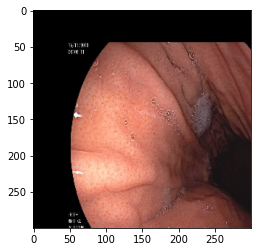

In [ ]:
plt.imshow(gen[0][1])
print(gen[1][0])
print(gen[1][1])

In [8]:
callback3 = tf.keras.callbacks.ModelCheckpoint(
                            filepath="/content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3-BAC.h5",
                            save_weights_only=True,
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True,
                            verbose=1)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                            initial_learning_rate=1e-3,
                            decay_steps=10000,
                            # decay_steps=(training_sammples // BATCH_SIZE) * 3.6,
                            decay_rate=0.97,
                            staircase = True)
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate=0.001, decay_steps=100, alpha=1e-7, name=None
# )
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule, rho=0.9, momentum=0.9, epsilon=1e-07)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.97)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics='accuracy')

In [13]:
model.load_weights("/content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3-BAC.h5")

In [14]:
model.evaluate(test_generator, batch_size=BATCH_SIZE,verbose=2)

24/24 - 15s - loss: 0.2203 - accuracy: 0.9703


[0.22028233110904694, 0.9702702760696411]

In [15]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
462/462 [==============================] - 459s 992ms/step - loss: 0.0484 - accuracy: 0.9869 - val_loss: 0.1565 - val_accuracy: 0.9647

Epoch 00001: val_accuracy improved from 0.96060 to 0.96467, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3-BAC.h5
Epoch 2/100
462/462 [==============================] - 461s 996ms/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.2134 - val_accuracy: 0.9579

Epoch 00002: val_accuracy did not improve from 0.96467
Epoch 3/100
462/462 [==============================] - 462s 999ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.2337 - val_accuracy: 0.9592

Epoch 00003: val_accuracy did not improve from 0.96467
Epoch 4/100
462/462 [==============================] - 461s 998ms/step - loss: 0.0060 - accuracy: 0.9978 - val_loss: 0.2153 - val_accuracy: 0.9592

Epoch 00004: val_accuracy did not improve from 0.96467
Epoch 5/100
462/462 [==============================] - 459s 993ms/step - loss: 0

KeyboardInterrupt: ignored

In [12]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
462/462 [==============================] - 5288s 11s/step - loss: 0.0225 - accuracy: 0.9930 - val_loss: 0.2347 - val_accuracy: 0.9511

Epoch 00001: val_accuracy improved from -inf to 0.95109, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3-BAC.h5
Epoch 2/100
462/462 [==============================] - 484s 1s/step - loss: 0.0144 - accuracy: 0.9956 - val_loss: 0.3253 - val_accuracy: 0.9429

Epoch 00002: val_accuracy did not improve from 0.95109
Epoch 3/100
462/462 [==============================] - 464s 1s/step - loss: 0.0191 - accuracy: 0.9940 - val_loss: 0.2038 - val_accuracy: 0.9606

Epoch 00003: val_accuracy improved from 0.95109 to 0.96060, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3-BAC.h5
Epoch 4/100
462/462 [==============================] - 467s 1s/step - loss: 0.0095 - accuracy: 0.9970 - val_loss: 0.2592 - val_accuracy: 0.9389

Epoch 00004: val_accuracy did not improv

KeyboardInterrupt: ignored

In [ ]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
462/462 [==============================] - 11135s 24s/step - loss: 2.1078 - accuracy: 0.3624 - val_loss: 3.4050 - val_accuracy: 0.1943

Epoch 00001: val_accuracy improved from -inf to 0.19429, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3-BAC.h5
Epoch 2/100
462/462 [==============================] - 425s 920ms/step - loss: 0.6262 - accuracy: 0.7837 - val_loss: 0.5120 - val_accuracy: 0.8383

Epoch 00002: val_accuracy improved from 0.19429 to 0.83832, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3-BAC.h5
Epoch 3/100
462/462 [==============================] - 414s 896ms/step - loss: 0.3128 - accuracy: 0.8917 - val_loss: 0.3101 - val_accuracy: 0.9049

Epoch 00003: val_accuracy improved from 0.83832 to 0.90489, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3-BAC.h5
Epoch 4/100
462/462 [==============================] - 411s 888ms/step

In [ ]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
462/462 [==============================] - 12002s 26s/step - loss: 2.1530 - accuracy: 0.3315 - val_loss: 2.0891 - val_accuracy: 0.3655

Epoch 00001: val_accuracy improved from -inf to 0.36549, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-aff.h5
Epoch 2/100
462/462 [==============================] - 433s 935ms/step - loss: 0.9638 - accuracy: 0.6729 - val_loss: 0.7542 - val_accuracy: 0.7745

Epoch 00002: val_accuracy improved from 0.36549 to 0.77446, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-aff.h5
Epoch 3/100
462/462 [==============================] - 422s 912ms/step - loss: 0.5050 - accuracy: 0.8323 - val_loss: 0.7954 - val_accuracy: 0.7391

Epoch 00003: val_accuracy did not improve from 0.77446
Epoch 4/100
462/462 [==============================] - 419s 907ms/step - loss: 0.3231 - accuracy: 0.8925 - val_loss: 0.3786 - val_accuracy: 0.8764

Epoch 00004: val_accuracy improved from 0.77446 to 0.87636, saving model to /content/drive/M

In [ ]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
457/457 [==============================] - 340s 745ms/step - loss: 0.5307 - accuracy: 0.9934 - val_loss: 0.1786 - val_accuracy: 0.9620

Epoch 00001: val_accuracy improved from 0.92663 to 0.96196, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-VAE.h5
Epoch 2/100
457/457 [==============================] - 341s 747ms/step - loss: 0.5210 - accuracy: 0.9965 - val_loss: 0.1897 - val_accuracy: 0.9647

Epoch 00002: val_accuracy improved from 0.96196 to 0.96467, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-VAE.h5
Epoch 3/100
457/457 [==============================] - 341s 746ms/step - loss: 0.5163 - accuracy: 0.9988 - val_loss: 0.1871 - val_accuracy: 0.9660

Epoch 00003: val_accuracy improved from 0.96467 to 0.96603, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-VAE.h5
Epoch 4/100
457/457 [==============================] - 341s 746ms/step - loss: 0.5132 - accuracy: 0.9992 - val_loss: 0.2071 - val_accuracy: 0.9552

Epoch 00004:

In [ ]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
457/457 [==============================] - 7624s 17s/step - loss: 0.0166 - accuracy: 0.9952 - val_loss: 0.5521 - val_accuracy: 0.9062

Epoch 00001: val_accuracy improved from -inf to 0.90625, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-VAE.h5
Epoch 2/100
457/457 [==============================] - 341s 746ms/step - loss: 0.0224 - accuracy: 0.9923 - val_loss: 0.2280 - val_accuracy: 0.9443

Epoch 00002: val_accuracy improved from 0.90625 to 0.94429, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-VAE.h5
Epoch 3/100
457/457 [==============================] - 341s 746ms/step - loss: 0.0062 - accuracy: 0.9979 - val_loss: 0.2967 - val_accuracy: 0.9253

Epoch 00003: val_accuracy did not improve from 0.94429
Epoch 4/100
457/457 [==============================] - 341s 746ms/step - loss: 0.0206 - accuracy: 0.9929 - val_loss: 0.2635 - val_accuracy: 0.9375

Epoch 00004: val_accuracy did not improve from 0.94429
Epoch 5/100
457/457 [=================

KeyboardInterrupt: ignored

In [ ]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
457/457 [==============================] - 7876s 17s/step - loss: 2.0938 - accuracy: 0.3779 - val_loss: 2.1607 - val_accuracy: 0.3220

Epoch 00001: val_accuracy improved from -inf to 0.32201, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-VAE.h5
Epoch 2/100
457/457 [==============================] - 343s 750ms/step - loss: 0.5244 - accuracy: 0.8323 - val_loss: 0.9138 - val_accuracy: 0.6590

Epoch 00002: val_accuracy improved from 0.32201 to 0.65897, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-VAE.h5
Epoch 3/100
457/457 [==============================] - 343s 751ms/step - loss: 0.2999 - accuracy: 0.9022 - val_loss: 0.9050 - val_accuracy: 0.6562

Epoch 00003: val_accuracy did not improve from 0.65897
Epoch 4/100
457/457 [==============================] - 343s 750ms/step - loss: 0.2284 - accuracy: 0.9247 - val_loss: 0.9816 - val_accuracy: 0.6970

Epoch 00004: val_accuracy improved from 0.65897 to 0.69701, saving model to /content/drive/My

In [ ]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
240/240 [==============================] - 4933s 21s/step - loss: 0.0084 - accuracy: 0.9978 - val_loss: 0.3307 - val_accuracy: 0.9579

Epoch 00001: val_accuracy improved from -inf to 0.95788, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-BAC.h5
Epoch 2/100
240/240 [==============================] - 186s 774ms/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 0.2648 - val_accuracy: 0.9565

Epoch 00002: val_accuracy did not improve from 0.95788
Epoch 3/100
240/240 [==============================] - 186s 773ms/step - loss: 0.0058 - accuracy: 0.9996 - val_loss: 0.2681 - val_accuracy: 0.9552

Epoch 00003: val_accuracy did not improve from 0.95788
Epoch 4/100
240/240 [==============================] - 186s 774ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.2291 - val_accuracy: 0.9620

Epoch 00004: val_accuracy improved from 0.95788 to 0.96196, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-BAC.h5
Epoch 5/100
240/240 [=================

In [ ]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
240/240 [==============================] - 2530s 10s/step - loss: 0.0181 - accuracy: 0.9936 - val_loss: 0.2521 - val_accuracy: 0.9579

Epoch 00001: val_accuracy improved from -inf to 0.95788, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-BAC.h5
Epoch 2/100
240/240 [==============================] - 187s 778ms/step - loss: 0.0068 - accuracy: 0.9983 - val_loss: 0.2780 - val_accuracy: 0.9348

Epoch 00002: val_accuracy did not improve from 0.95788
Epoch 3/100
240/240 [==============================] - 188s 781ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.2592 - val_accuracy: 0.9470

Epoch 00003: val_accuracy did not improve from 0.95788
Epoch 4/100
240/240 [==============================] - 188s 779ms/step - loss: 0.0272 - accuracy: 0.9915 - val_loss: 0.6350 - val_accuracy: 0.8832

Epoch 00004: val_accuracy did not improve from 0.95788
Epoch 5/100
240/240 [==============================] - 188s 781ms/step - loss: 0.0142 - accuracy: 0.9957 - val_loss

In [ ]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
240/240 [==============================] - 2302s 10s/step - loss: 0.6497 - accuracy: 0.8494 - val_loss: 0.2223 - val_accuracy: 0.9429

Epoch 00001: val_accuracy improved from -inf to 0.94293, saving model to /content/drive/MyDrive/Segmentation/efficient-b3.h5
Epoch 2/100
240/240 [==============================] - 185s 767ms/step - loss: 0.0421 - accuracy: 0.9851 - val_loss: 0.2171 - val_accuracy: 0.9443

Epoch 00002: val_accuracy improved from 0.94293 to 0.94429, saving model to /content/drive/MyDrive/Segmentation/efficient-b3.h5
Epoch 3/100
240/240 [==============================] - 184s 766ms/step - loss: 0.0355 - accuracy: 0.9891 - val_loss: 0.2795 - val_accuracy: 0.9321

Epoch 00003: val_accuracy did not improve from 0.94429
Epoch 4/100
240/240 [==============================] - 185s 768ms/step - loss: 0.0499 - accuracy: 0.9841 - val_loss: 0.2327 - val_accuracy: 0.9429

Epoch 00004: val_accuracy did not improve from 0.94429
Epoch 5/100
240/240 [=========================

In [ ]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
240/240 [==============================] - 2983s 12s/step - loss: 2.6229 - accuracy: 0.2703 - val_loss: 2.3314 - val_accuracy: 0.2038

Epoch 00001: val_accuracy improved from -inf to 0.20380, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-BAC.h5
Epoch 2/100
240/240 [==============================] - 188s 783ms/step - loss: 1.0869 - accuracy: 0.6793 - val_loss: 1.1772 - val_accuracy: 0.6440

Epoch 00002: val_accuracy improved from 0.20380 to 0.64402, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-BAC.h5
Epoch 3/100
240/240 [==============================] - 188s 782ms/step - loss: 0.5927 - accuracy: 0.8291 - val_loss: 0.6491 - val_accuracy: 0.8043

Epoch 00003: val_accuracy improved from 0.64402 to 0.80435, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-BAC.h5
Epoch 4/100
240/240 [==============================] - 188s 780ms/step - loss: 0.3521 - accuracy: 0.8891 - val_loss: 0.5056 - val_accuracy: 0.8668

Epoch 00004: val

KeyboardInterrupt: ignored

In [ ]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
210/210 [==============================] - 2986s 14s/step - loss: 0.3443 - accuracy: 0.8844 - val_loss: 5.2838 - val_accuracy: 0.0992

Epoch 00001: val_accuracy improved from -inf to 0.09918, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-aff.h5
Epoch 2/100
210/210 [==============================] - 171s 811ms/step - loss: 0.1102 - accuracy: 0.9655 - val_loss: 5.7426 - val_accuracy: 0.1019

Epoch 00002: val_accuracy improved from 0.09918 to 0.10190, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-aff.h5
Epoch 3/100
210/210 [==============================] - 171s 809ms/step - loss: 0.0741 - accuracy: 0.9784 - val_loss: 2.5414 - val_accuracy: 0.1005

Epoch 00003: val_accuracy did not improve from 0.10190
Epoch 4/100
210/210 [==============================] - 170s 807ms/step - loss: 0.0495 - accuracy: 0.9851 - val_loss: 6.3823 - val_accuracy: 0.2405

Epoch 00004: val_accuracy improved from 0.10190 to 0.24049, saving model to /content/drive/My

KeyboardInterrupt: ignored

In [ ]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
210/210 [==============================] - 164s 778ms/step - loss: 0.0666 - accuracy: 0.9761 - val_loss: 0.3826 - val_accuracy: 0.9130

Epoch 00001: val_accuracy did not improve from 0.91712
Epoch 2/100
210/210 [==============================] - 165s 781ms/step - loss: 0.0508 - accuracy: 0.9824 - val_loss: 0.3326 - val_accuracy: 0.9185

Epoch 00002: val_accuracy improved from 0.91712 to 0.91848, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-aff.h5
Epoch 3/100
210/210 [==============================] - 164s 779ms/step - loss: 0.0690 - accuracy: 0.9781 - val_loss: 0.6402 - val_accuracy: 0.8967

Epoch 00003: val_accuracy did not improve from 0.91848
Epoch 4/100
210/210 [==============================] - 164s 778ms/step - loss: 0.0476 - accuracy: 0.9845 - val_loss: 0.3627 - val_accuracy: 0.9103

Epoch 00004: val_accuracy did not improve from 0.91848
Epoch 5/100
210/210 [==============================] - 163s 773ms/step - loss: 0.0480 - accuracy: 0.9828 - val_

KeyboardInterrupt: ignored

In [ ]:
H = model.fit(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

Epoch 1/100
210/210 [==============================] - 176s 789ms/step - loss: 1.9092 - accuracy: 0.3559 - val_loss: 204.1170 - val_accuracy: 0.3288

Epoch 00001: val_accuracy improved from -inf to 0.32880, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-aff.h5
Epoch 2/100
210/210 [==============================] - 164s 780ms/step - loss: 1.2383 - accuracy: 0.5857 - val_loss: 0.8367 - val_accuracy: 0.7378

Epoch 00002: val_accuracy improved from 0.32880 to 0.73777, saving model to /content/drive/MyDrive/Segmentation/efficient-b3-aff.h5
Epoch 3/100
210/210 [==============================] - 165s 782ms/step - loss: 0.8020 - accuracy: 0.7356 - val_loss: 6.2278 - val_accuracy: 0.2011

Epoch 00003: val_accuracy did not improve from 0.73777
Epoch 4/100
210/210 [==============================] - 165s 784ms/step - loss: 0.5868 - accuracy: 0.8001 - val_loss: 0.5745 - val_accuracy: 0.7880

Epoch 00004: val_accuracy improved from 0.73777 to 0.78804, saving model to /content/drive

KeyboardInterrupt: ignored

In [ ]:
model.load_weights(filepath="/content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3.h5")

In [ ]:
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = EPOCHS, 
    # validation_split = 0.1,
    validation_data=(test_images, test_labels), 
    callbacks=[callback3]
    )

Epoch 1/100
93/93 [==============================] - 100s 777ms/step - loss: 3.6393 - accuracy: 0.1588 - val_loss: 2.4898 - val_accuracy: 0.1000

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3.h5
Epoch 2/100
93/93 [==============================] - 69s 742ms/step - loss: 2.1655 - accuracy: 0.3128 - val_loss: 2.5365 - val_accuracy: 0.0986

Epoch 00002: val_accuracy did not improve from 0.10000
Epoch 3/100
93/93 [==============================] - 69s 742ms/step - loss: 1.5933 - accuracy: 0.4919 - val_loss: 2.0623 - val_accuracy: 0.2716

Epoch 00003: val_accuracy improved from 0.10000 to 0.27162, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3.h5
Epoch 4/100
93/93 [==============================] - 69s 743ms/step - loss: 1.8543 - accuracy: 0.4611 - val_loss: 34.0295 - val_accuracy: 0.1878

Epoch 00004: val_accuracy did not improve from 0

In [ ]:
results = model.evaluate(test_images, test_labels)

print("Loss of test model is  ", results[0])
print("Accuracy of test model is ", results[1]*100, "%")

results = model.evaluate(train_images, train_labels)

print("Loss of train model  is ", results[0])
print("Accuracy of train model is ", results[1]*100, "%")

24/24 [==============================] - 46s 465ms/step - loss: 0.1638 - accuracy: 0.9676
Loss of test model is   0.16384762525558472
Accuracy of test model is  96.75675630569458 %


In [ ]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(EPOCHS)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()
plot_accuracy_loss_chart(H)

NameError: ignored

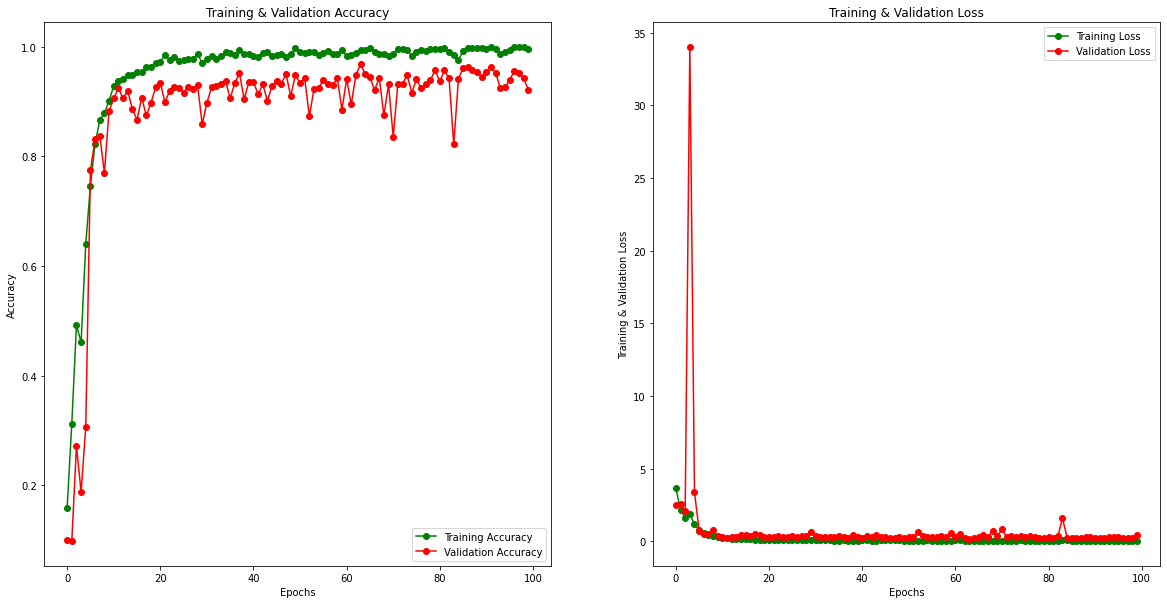

In [ ]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(EPOCHS)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()
plot_accuracy_loss_chart(history)

In [ ]:
def calculate_sen_spec(cm):
    size = len(cm)
    TP, F, TN, TF, f1score, total = 0, 0, 0, 0, 0, 0
    total += sum([sum([cm[i][j] for i in range(size)]) for j in range(size)])
    TP += sum([cm[i][i] for i in range(size)])
    F = total - TP
    TN = (size-2)*total+TP
    sen = TP/(TP+F)
    spec = TN/(TN+F)
    acc = (TP+TN)/(size*total)
    pre = TP/(TP+F)
    f1score = 2*TP/(2*TP+2*F)

    return sen, spec, acc, pre, f1score
calculate_sen_spec(cm)

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
# print(predictions)
print(classification_report(
    np.argmax(test_labels, axis=1), 
    predictions, 
    target_names = class_names))

                 precision    recall  f1-score   support

     1 Hầu họng       1.00      0.97      0.99        74
    2 Thực quản       1.00      1.00      1.00        74
       3 Tâm vị       1.00      0.99      0.99        74
      4 Thân vị       0.87      0.92      0.89        74
     5 Phình vị       0.99      0.92      0.95        74
      6 Hang vị       0.95      1.00      0.97        74
  7 Bờ cong lớn       0.97      0.93      0.95        74
  8 Bờ cong nhỏ       0.99      0.97      0.98        74
9 Hành tá tràng       0.94      1.00      0.97        74
    10 Tá tràng       0.99      0.97      0.98        74

       accuracy                           0.97       740
      macro avg       0.97      0.97      0.97       740
   weighted avg       0.97      0.97      0.97       740



In [ ]:
import pandas as pd
cm = confusion_matrix(np.argmax(test_labels, axis=1), predictions)
# cm = pd.DataFrame(cm, index = class_names, columns = class_names)
cm

,1 Hầu họng,2 Thực quản,3 Tâm vị,4 Thân vị,5 Phình vị,6 Hang vị,7 Bờ cong lớn,8 Bờ cong nhỏ,9 Hành tá tràng,10 Tá tràng
1 Hầu họng,72,0,0,0,0,0,0,0,1,1
2 Thực quản,0,74,0,0,0,0,0,0,0,0
3 Tâm vị,0,0,73,0,0,1,0,0,0,0
4 Thân vị,0,0,0,68,0,3,2,1,0,0
5 Phình vị,0,0,0,4,68,0,0,0,2,0
6 Hang vị,0,0,0,0,0,74,0,0,0,0
7 Bờ cong lớn,0,0,0,5,0,0,69,0,0,0
8 Bờ cong nhỏ,0,0,0,1,1,0,0,72,0,0
9 Hành tá tràng,0,0,0,0,0,0,0,0,74,0
10 Tá tràng,0,0,0,0,0,0,0,0,2,72


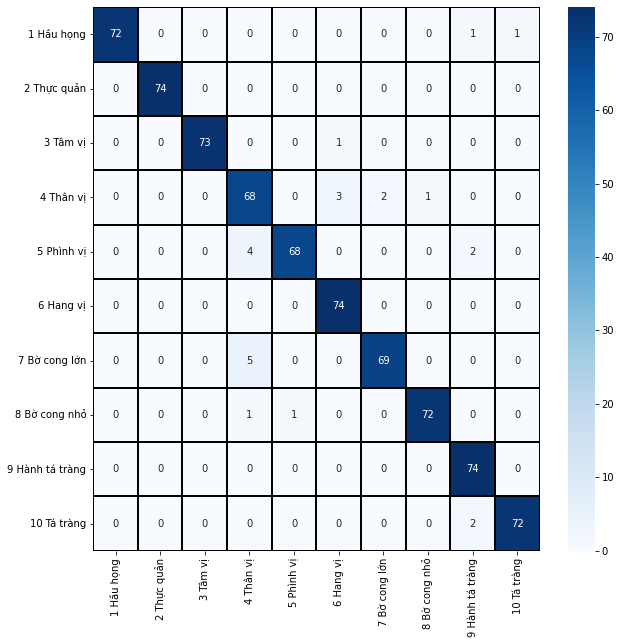

In [ ]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

In [ ]:
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = EPOCHS, 
    # validation_split = 0.1,
    validation_data=(test_images, test_labels), 
    callbacks=[callback3]
    )

Epoch 1/100
93/93 [==============================] - 104s 788ms/step - loss: 3.2740 - accuracy: 0.1736 - val_loss: 2.3590 - val_accuracy: 0.1000

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3.h5
Epoch 2/100
93/93 [==============================] - 69s 746ms/step - loss: 2.1179 - accuracy: 0.3162 - val_loss: 2.2781 - val_accuracy: 0.1000

Epoch 00002: val_accuracy did not improve from 0.10000
Epoch 3/100
93/93 [==============================] - 69s 746ms/step - loss: 1.6110 - accuracy: 0.4949 - val_loss: 2.5986 - val_accuracy: 0.1297

Epoch 00003: val_accuracy improved from 0.10000 to 0.12973, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-b3.h5
Epoch 4/100
93/93 [==============================] - 69s 743ms/step - loss: 1.4268 - accuracy: 0.5780 - val_loss: 4.7812 - val_accuracy: 0.3824

Epoch 00004: val_accuracy improved from 0.12973 t

KeyboardInterrupt: ignored

In [ ]:
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = EPOCHS, 
    # validation_split = 0.1,
    validation_data=(test_images, test_labels), 
    callbacks=[callback3]
    )

Epoch 1/100
93/93 [==============================] - 62s 517ms/step - loss: 3.4114 - accuracy: 0.1696 - val_loss: 2.7158 - val_accuracy: 0.1000

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /content/efficient-b2.h5
Epoch 2/100
93/93 [==============================] - 45s 480ms/step - loss: 2.1318 - accuracy: 0.3152 - val_loss: 3.1923 - val_accuracy: 0.1000

Epoch 00002: val_accuracy did not improve from 0.10000
Epoch 3/100
93/93 [==============================] - 45s 481ms/step - loss: 1.5873 - accuracy: 0.4932 - val_loss: 2.8531 - val_accuracy: 0.1730

Epoch 00003: val_accuracy improved from 0.10000 to 0.17297, saving model to /content/efficient-b2.h5
Epoch 4/100
93/93 [==============================] - 45s 480ms/step - loss: 1.0602 - accuracy: 0.6510 - val_loss: 1.8030 - val_accuracy: 0.3797

Epoch 00004: val_accuracy improved from 0.17297 to 0.37973, saving model to /content/efficient-b2.h5
Epoch 5/100
93/93 [==============================] - 45s 481ms/st

In [ ]:
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 16, 
    epochs = EPOCHS, 
    # validation_split = 0.1,
    validation_data=(test_images, test_labels), 
    callbacks=[callback3]
    )

Epoch 1/100
185/185 [==============================] - 106s 415ms/step - loss: 3.1341 - accuracy: 0.1723 - val_loss: 2.5301 - val_accuracy: 0.1365

Epoch 00001: val_accuracy improved from -inf to 0.13649, saving model to /content/efficient-b3.h5
Epoch 2/100
185/185 [==============================] - 74s 397ms/step - loss: 2.1307 - accuracy: 0.2818 - val_loss: 3.4730 - val_accuracy: 0.0946

Epoch 00002: val_accuracy did not improve from 0.13649
Epoch 3/100
185/185 [==============================] - 74s 398ms/step - loss: 1.6740 - accuracy: 0.4311 - val_loss: 2.2873 - val_accuracy: 0.2703

Epoch 00003: val_accuracy improved from 0.13649 to 0.27027, saving model to /content/efficient-b3.h5
Epoch 4/100
185/185 [==============================] - 73s 397ms/step - loss: 1.3023 - accuracy: 0.5926 - val_loss: 1.0399 - val_accuracy: 0.6554

Epoch 00004: val_accuracy improved from 0.27027 to 0.65541, saving model to /content/efficient-b3.h5
Epoch 5/100
185/185 [==============================] - 7

KeyboardInterrupt: ignored

In [ ]:
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 16, 
    epochs = EPOCHS, 
    # validation_split = 0.1,
    validation_data=(test_images, test_labels), 
    callbacks=[callback3]
    )

Epoch 1/100
185/185 [==============================] - 79s 384ms/step - loss: 1.1181 - accuracy: 0.6338 - val_loss: 5.5021 - val_accuracy: 0.0541

Epoch 00001: val_accuracy improved from 0.00000 to 0.05405, saving model to /content/efficient-b3.h5
Epoch 2/100
185/185 [==============================] - 71s 384ms/step - loss: 0.7425 - accuracy: 0.7476 - val_loss: 1.7002 - val_accuracy: 0.4595

Epoch 00002: val_accuracy improved from 0.05405 to 0.45946, saving model to /content/efficient-b3.h5
Epoch 3/100
185/185 [==============================] - 71s 384ms/step - loss: 0.5470 - accuracy: 0.8122 - val_loss: 0.2753 - val_accuracy: 0.8986

Epoch 00003: val_accuracy improved from 0.45946 to 0.89865, saving model to /content/efficient-b3.h5
Epoch 4/100
185/185 [==============================] - 71s 384ms/step - loss: 0.3882 - accuracy: 0.8672 - val_loss: 0.6459 - val_accuracy: 0.8243

Epoch 00004: val_accuracy did not improve from 0.89865
Epoch 5/100
185/185 [==============================] -

KeyboardInterrupt: ignored

In [ ]:
results = model.evaluate(test_images, test_labels)

print("Loss of test model is  ", results[0])
print("Accuracy of test model is ", results[1]*100, "%")

results = model.evaluate(train_images, train_labels)

print("Loss of train model  is ", results[0])
print("Accuracy of train model is ", results[1]*100, "%")

24/24 [==============================] - 3s 115ms/step - loss: 0.2304 - accuracy: 0.9446
Loss of test model is   0.23042534291744232
Accuracy of test model is  94.45946216583252 %
93/93 [==============================] - 11s 118ms/step - loss: 0.0086 - accuracy: 0.9966
Loss of train model  is  0.008570751175284386
Accuracy of train model is  99.66216087341309 %


In [ ]:
TRAIN_PATH = "/content/NICS_DATA/data_NICS/train"
TEST_PATH = "/content/NICS_DATA/data_NICS/test"
#Use keras to generate data for our model
from keras.preprocessing.image import ImageDataGenerator
import cv2 
# we create two instances with the same arguments
data_gen_args = dict(validation_split=0,
                     rotation_range=45,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                    #  horizontal_flip=True,
                     rescale=1./255,
                     fill_mode='nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator(
                      rescale=1./255,                    
                    )

train_generator = image_datagen.flow_from_directory(TRAIN_PATH,
                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                        color_mode="rgb",
                        shuffle=True,
                        interpolation="nearest",
                        class_mode="categorical",
                        batch_size = BATCH_SIZE,
                        subset='training')
test_generator = test_datagen.flow_from_directory(TEST_PATH,
                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                        color_mode="rgb",
                        shuffle=False,
                        class_mode='categorical',
                        batch_size=BATCH_SIZE,
                        interpolation="nearest")
#val_generator = image_datagen.flow(X_val1, Y_val1, batch_size=2)

training_sammples = 2960
# training_org_sammples = train_generator_org.samples
test_samples = 740

Found 2960 images belonging to 10 classes.
Found 740 images belonging to 10 classes.


In [ ]:
print(next(train_generator)[1][1])

[0.01       0.01       0.01       0.90999997 0.01       0.01
 0.01       0.01       0.01       0.01      ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: This function is deprecated. Please call randint(1, 63 + 1) instead


[0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.7777223  0.14227764]


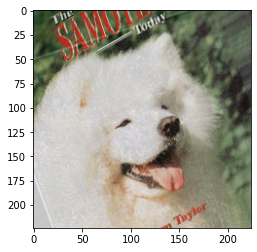

In [ ]:
gen = next(train_generator)

plt.imshow(gen[0][1])
print(gen[1][1])

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=64, ncols=1, figsize=(200,200))

gen = next(train_generator)
for i in range(64):
    ax[i].imshow(gen[0][i])
    print(gen[1][i])

# for i in range(12):
#     image = next(train_generator)[0][i]
#     ax[i].imshow(image)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
H = model.fit_generator(train_generator, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/90
141/141 [==============================] - 299s 2s/step - loss: 3.2872 - accuracy: 0.1066 - val_loss: 2.3193 - val_accuracy: 0.1081

Epoch 00001: val_accuracy improved from -inf to 0.10809, saving model to /content/drive/MyDrive/COLAB/Viettel/imagewoof2/model_weight.h5
Epoch 2/90
141/141 [==============================] - 246s 2s/step - loss: 2.5571 - accuracy: 0.1261 - val_loss: 2.2960 - val_accuracy: 0.1250

Epoch 00002: val_accuracy improved from 0.10809 to 0.12500, saving model to /content/drive/MyDrive/COLAB/Viettel/imagewoof2/model_weight.h5
Epoch 3/90
141/141 [==============================] - 245s 2s/step - loss: 2.3575 - accuracy: 0.1563 - val_loss: 2.5111 - val_accuracy: 0.1624

Epoch 00003: val_accuracy improved from 0.12500 to 0.16240, saving model to /content/drive/MyDrive/COLAB/Viettel/imagewoof2/model_weight.h5
Epoch 4/90
141/141 [==============================] - 243s 2s/step - loss: 2.2888 - accuracy: 0.1828 - val_loss: 2.1574 - val_accuracy: 0.2149

Epoch 0

KeyboardInterrupt: ignored

In [ ]:
model.load_weights(filepath="/content/drive/MyDrive/COLAB/Viettel/imagewoof2/model_weights_now.h5")

In [ ]:
model.evaluate(test_generator, batch_size=BATCH_SIZE,verbose=2)

62/62 - 1244s - loss: 0.8368 - accuracy: 0.7312


[0.8368244171142578, 0.731229305267334]

In [ ]:
H = model.fit_generator(train_generator_org, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/90
141/141 [==============================] - 3285s 23s/step - loss: 0.4955 - accuracy: 0.8261 - val_loss: 0.8364 - val_accuracy: 0.7321

Epoch 00001: val_accuracy improved from -inf to 0.73207, saving model to /content/drive/MyDrive/COLAB/Viettel/imagewoof2/model_weight.h5
Epoch 2/90
141/141 [==============================] - 183s 1s/step - loss: 0.4916 - accuracy: 0.8299 - val_loss: 0.8368 - val_accuracy: 0.7316

Epoch 00002: val_accuracy did not improve from 0.73207
Epoch 3/90
141/141 [==============================] - 183s 1s/step - loss: 0.4850 - accuracy: 0.8297 - val_loss: 0.8367 - val_accuracy: 0.7318

Epoch 00003: val_accuracy did not improve from 0.73207
Epoch 4/90
141/141 [==============================] - 183s 1s/step - loss: 0.4869 - accuracy: 0.8264 - val_loss: 0.8367 - val_accuracy: 0.7331

Epoch 00004: val_accuracy improved from 0.73207 to 0.73309, saving model to /content/drive/MyDrive/COLAB/Viettel/imagewoof2/model_weight.h5
Epoch 5/90
141/141 [===============

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f551d31b950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 22/90
 47/141 [=========>....................] - ETA: 1:46 - loss: 0.4547 - accuracy: 0.8391

KeyboardInterrupt: ignored

In [ ]:
data_gen_args_aug = dict(validation_split=VALIDATION_SPLIT,
                     rotation_range=45,
                     width_shift_range=20,
                     height_shift_range=10,
                     brightness_range = (0.5, 1),
                     shear_range=20,
                     zoom_range=0.3,
                     channel_shift_range = 50,
                     horizontal_flip=True,
                     rescale=1./255,
                     fill_mode='nearest')
image_datagen_aug = ImageDataGenerator(**data_gen_args_aug)
test_datagen_aug = ImageDataGenerator(rescale=1./255)

# Provide the same seed and keyword arguments to the fit and flow methods

#image_datagen.fit(X_train)
train_generator_aug = image_datagen_aug.flow_from_directory(TRAIN_PATH,
                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                        color_mode="rgb",
                        shuffle=True,
                        interpolation="nearest",
                        class_mode="categorical", 
                        batch_size = BATCH_SIZE,
                        subset='training')
test_generator_aug = test_datagen_aug.flow_from_directory(TEST_PATH,
                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                        color_mode="rgb",
                        shuffle=False,
                        class_mode='categorical',
                        batch_size=BATCH_SIZE,
                        interpolation="nearest")

test_samples = test_generator.samples

Found 9025 images belonging to 10 classes.
Found 3929 images belonging to 10 classes.


In [ ]:
image = next(test_generator_aug)[0][1]
image

In [ ]:
fig, ax = plt.subplots(nrows=64, ncols=1, figsize=(250,250))

for i in range(64):

  # convert to unsigned integers for plotting
    image = next(train_generator_aug)[0][i]

    # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
    # image = np.squeeze(image)

    # plot raw pixel data
    ax[i].imshow(image)
    # ax[i].axis('off')

In [ ]:
model.load_weights(filepath="/content/drive/MyDrive/COLAB/Viettel/imagewoof2/model_weight.h5")

In [ ]:
model.evaluate(test_generator, batch_size=BATCH_SIZE,verbose=2)

62/62 - 25s - loss: 0.8381 - accuracy: 0.7371


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f551d31b950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


[0.8380758166313171, 0.7370832562446594]

In [ ]:
H = model.fit_generator(train_generator_aug, steps_per_epoch=training_sammples//BATCH_SIZE,
              validation_data=test_generator_aug,
              validation_steps=test_samples//BATCH_SIZE,
              verbose=1,
              epochs=EPOCHS
              # callbacks=NULL)
              ,callbacks=[callback3]
              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/90
 34/141 [======>.......................] - ETA: 2:42 - loss: 0.8813 - accuracy: 0.7080

KeyboardInterrupt: ignored

In [ ]:
folder = '/content/drive/MyDrive/COLAB/Viettel/imagewoof2-160/train/'
images = next(os.walk(folder))[1]
print(images)

['n02093754', 'n02087394', 'n02086240', 'n02099601', 'n02096294', 'n02105641', 'n02111889', 'n02088364', 'n02115641', 'n02089973']


In [ ]:
# type = [os.walk(os.path.join(folder, i)) for i in os.listdir(folder)]
x_train = []
for i in os.listdir(folder):
    images = next(os.walk(os.path.join(folder, i)))[2]
    for image in images:
        # print(os.path.join(os.path.join(folder, i), image))
        image = io.imread(os.path.join(os.path.join(folder, i), image))
        # x_train.append(image)